In [ ]:
%tensorflow_version 1.x
!pip install keras-vggface
!pip install scikit-image
!pip install pydot

TensorFlow 1.x selected.


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.python.lib.io import file_io

%matplotlib inline

import keras
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras_vggface.vggface import VGGFace
from keras.utils import plot_model
from sklearn.metrics import *
from keras.engine import Model
from keras.layers import Input, Flatten, Dense, Activation, Conv2D, MaxPool2D, BatchNormalization, Dropout, MaxPooling2D
import skimage
from skimage.transform import rescale, resize

import pydot

Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print(tf.__version__)
print(keras.__version__)

1.15.2
2.3.1


In [ ]:
EPOCHS = 100
BS = 128
DROPOUT_RATE = 0.5
FROZEN_LAYER_NUM = 201

ADAM_LEARNING_RATE = 0.001
SGD_LEARNING_RATE = 0.01
SGD_DECAY = 0.0001

Resize_pixelsize = 197

In [ ]:
vgg_notop = VGGFace(model='senet50', include_top=False, input_shape=(Resize_pixelsize, Resize_pixelsize, 3), pooling='avg')
last_layer = vgg_notop.get_layer('avg_pool').output
x = Flatten(name='flatten')(last_layer)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(4096, activation='relu', name='fc6')(x)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(1024, activation='relu', name='fc7')(x)
x = Dropout(DROPOUT_RATE)(x)

batch_norm_indices = [2, 6, 9, 12, 21, 25, 28, 31, 42, 45, 48, 59, 62, 65, 74, 78, 81, 84, 95, 98, 101, 112, 115, 118, 129, 132, 135, 144, 148, 151, 154, 165, 168, 171, 182, 185, 188, 199, 202, 205, 216, 219, 222, 233, 236, 239, 248, 252, 255, 258, 269, 272, 275]    
for i in range(FROZEN_LAYER_NUM):
    if i not in batch_norm_indices:
        vgg_notop.layers[i].trainable = False

out = Dense(7, activation='softmax', name='classifier')(x)

model = Model(vgg_notop.input, out)


optim = keras.optimizers.Adam(lr=ADAM_LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
sgd = keras.optimizers.SGD(lr=SGD_LEARNING_RATE, momentum=0.9, decay=SGD_DECAY, nesterov=True)
rlrop = keras.callbacks.ReduceLROnPlateau(monitor='val_acc',mode='max',factor=0.5, patience=10, min_lr=0.00001, verbose=1)

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


104947712/104944616 [==============================] - 2s 0us/step


In [ ]:
! rm -rf train; mkdir train
! unzip -q '/content/drive/My Drive/Facial Expression/Facial_Expression/train.zip' -d train

In [ ]:
! rm -rf dev; mkdir dev
! unzip -q '/content/drive/My Drive/Facial Expression/Facial_Expression/test-public.zip' -d dev
! rm -rf test; mkdir test
! unzip -q '/content/drive/My Drive/Facial Expression/Facial_Expression/test-private.zip' -d test

In [ ]:
%%bash
root='/content/test/'
IFS=$(echo -en "\n\b")
(for dir in $(ls -1 "$root")
    do printf "$dir: " && ls -i "$root$dir" | wc -l
 done)

0 angry: 491
1 disgust: 55
2 fear: 528
3 happy: 879
4 sad: 594
5 surprise: 416
6 neutral: 626


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_datagen(dataset, aug=False):
    if aug:
        datagen = ImageDataGenerator(
                            rescale=1./255,
                            featurewise_center=False,
                            featurewise_std_normalization=False,
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.1,
                            horizontal_flip=True)
    else:
        datagen = ImageDataGenerator(rescale=1./255)

    return datagen.flow_from_directory(
            dataset,
            target_size=(197, 197),
            color_mode='rgb',
            shuffle = True,
            class_mode='categorical',
            batch_size=32)

In [ ]:
train_generator  = get_datagen('/content/train', True)
dev_generator    = get_datagen('/content/dev')
test_generator  = get_datagen('/content/test')

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [ ]:
history = model.fit_generator(
    generator = train_generator,
    validation_data=dev_generator, 
    steps_per_epoch=28709// BS,
    validation_steps=3509 // BS,
    shuffle=True,
    epochs=100,
    callbacks=[rlrop],
    use_multiprocessing=True,
)

Epoch 1/100
224/224 [==============================] - 75s 333ms/step - loss: 2.1753 - accuracy: 0.2208 - val_loss: 3.1286 - val_accuracy: 0.2569
Epoch 2/100
  1/224 [..............................] - ETA: 27s - loss: 1.8526 - accuracy: 0.3750

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


224/224 [==============================] - 69s 308ms/step - loss: 1.6483 - accuracy: 0.3305 - val_loss: 1.9576 - val_accuracy: 0.1551
Epoch 3/100
224/224 [==============================] - 71s 316ms/step - loss: 1.5791 - accuracy: 0.3508 - val_loss: 1.8155 - val_accuracy: 0.2882
Epoch 4/100
224/224 [==============================] - 74s 332ms/step - loss: 1.5257 - accuracy: 0.3856 - val_loss: 1.5390 - val_accuracy: 0.3299
Epoch 5/100
224/224 [==============================] - 76s 338ms/step - loss: 1.4420 - accuracy: 0.4188 - val_loss: 1.5171 - val_accuracy: 0.4146
Epoch 6/100
224/224 [==============================] - 74s 332ms/step - loss: 1.3942 - accuracy: 0.4383 - val_loss: 1.4217 - val_accuracy: 0.4653
Epoch 7/100
224/224 [==============================] - 75s 334ms/step - loss: 1.3445 - accuracy: 0.4561 - val_loss: 1.2404 - val_accuracy: 0.4884
Epoch 8/100
224/224 [==============================] - 75s 334ms/step - loss: 1.3463 - accuracy: 0.4598 - val_loss: 1.3145 - val_accurac

In [ ]:
print('\n# Evaluate on dev data')
results_dev = model.evaluate_generator(dev_generator, 3509 // BS)
print('dev loss, dev acc:', results_dev)


# Evaluate on dev data
dev loss, dev acc: [0.5927923917770386, 0.6898148059844971]


In [ ]:
print('\n# Evaluate on test data')
results_test = model.evaluate_generator(test_generator, 3509 // BS)
print('test loss, test acc:', results_test)


# Evaluate on test data
test loss, test acc: [1.1683043241500854, 0.6678240895271301]


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])


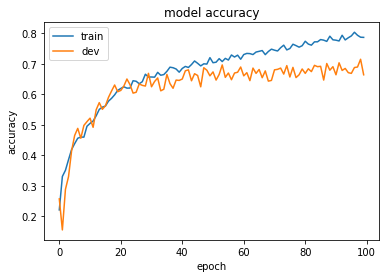

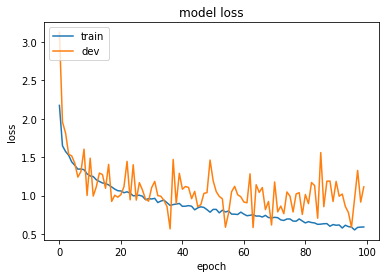

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

In [ ]:
epoch_str = '-EPOCHS_' + str(EPOCHS)
test_acc = 'test_acc_%.3f' % results_test[1]
model.save('/content/drive/My Drive/Facial Expression/Facial_Expression/models/' + 'SENET50' + epoch_str + test_acc + '.h5')